/var/folders/8l/dq9nhgmx5gj01xrwhwzb41s40000gn/T/ipykernel_26730/2269424186.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states = torch.FloatTensor(states)


gamma: 0.8, Average Return: -28493.36
gamma: 0.9, Average Return: -19692.14
gamma: 0.99, Average Return: -8167.52


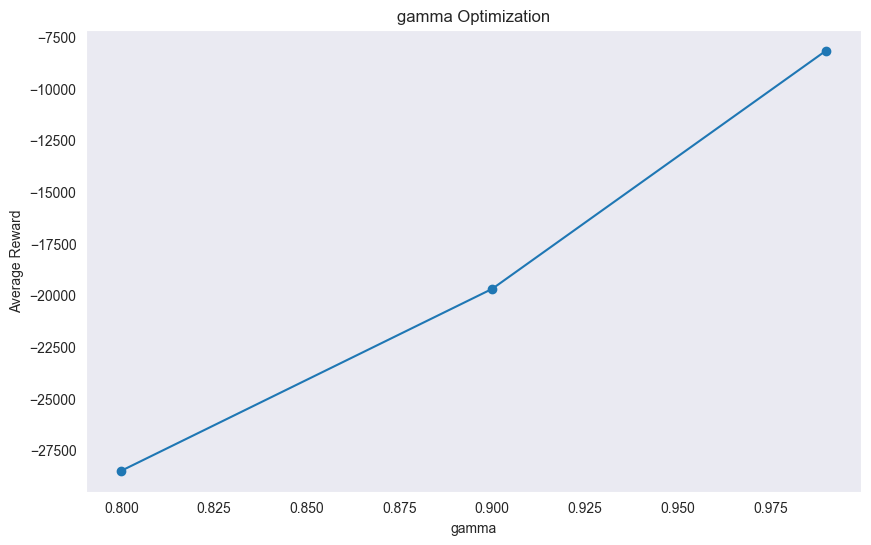

Optimal gamma: 0.99
lr: 0.0001, Average Return: -12135.82
lr: 0.001, Average Return: -6870.08
lr: 0.01, Average Return: -26846.2


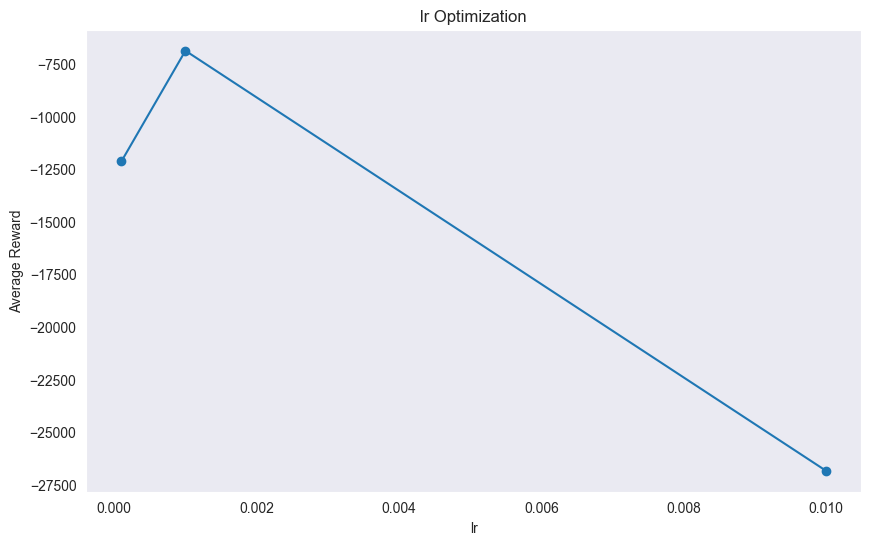

Optimal lr: 0.001
epsilon: 0.1, Average Return: -474.7
epsilon: 0.2, Average Return: -358.82
epsilon: 0.5, Average Return: -836.48
epsilon: 1.0, Average Return: -40918.26


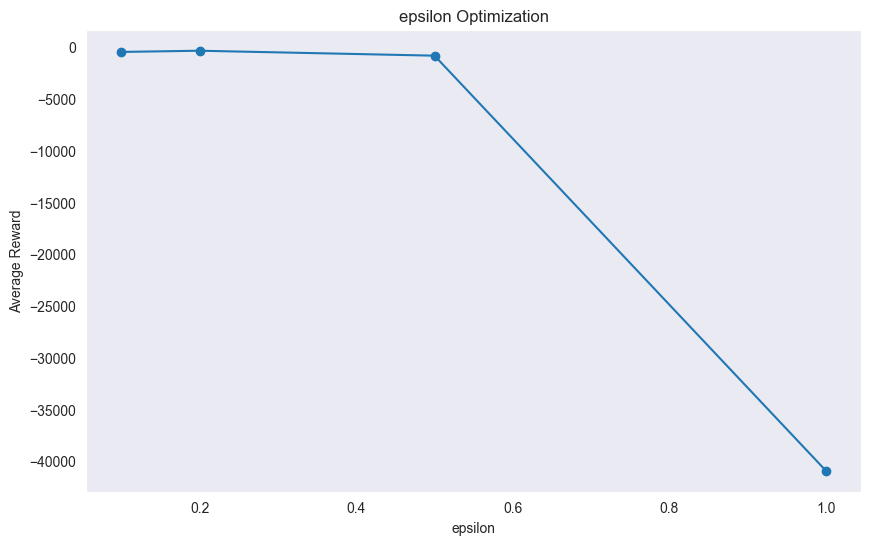

Optimal epsilon: 0.2
buffer_size: 1000, Average Return: -28903.08
buffer_size: 2000, Average Return: -47097.6
buffer_size: 3000, Average Return: -40838.6


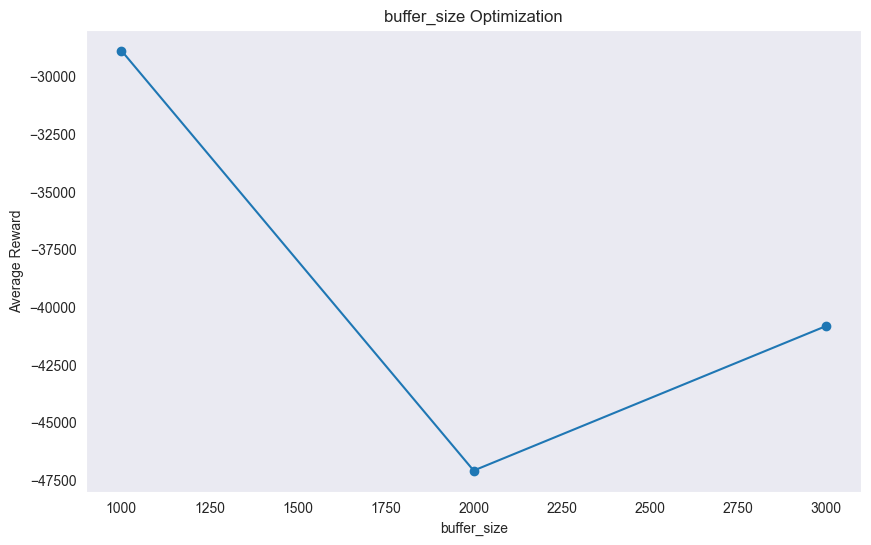

Optimal buffer_size: 1000
episodes: 50, Average Return: -39689.06
Episode: 100, Total Reward: -2510.0
episodes: 100, Average Return: -29292.84
Episode: 100, Total Reward: -25275.0
Episode: 200, Total Reward: -1934.0
episodes: 200, Average Return: -34652.495


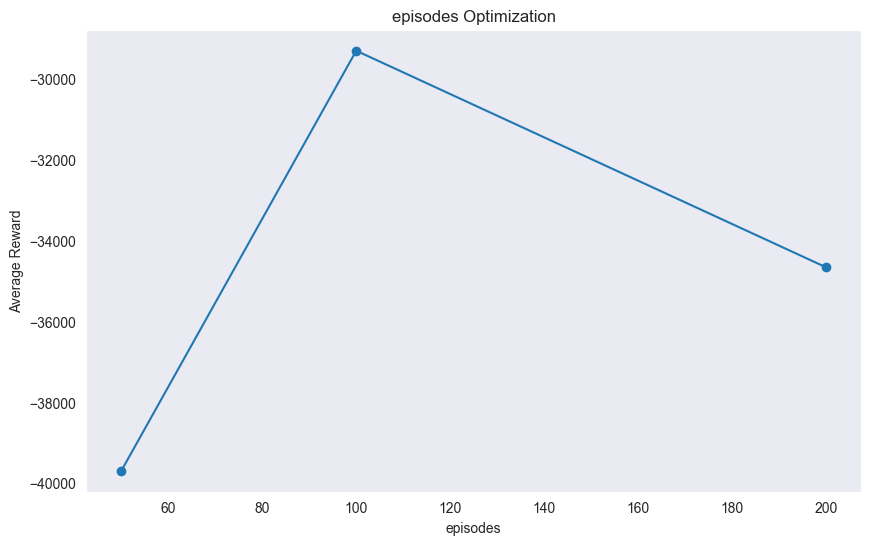

Optimal episodes: 100
Episode: 100, Total Reward: -2189.0
Episode: 200, Total Reward: -2213.0
sync_interval: 10, Average Return: -25766.735
Episode: 100, Total Reward: -18758.0
Episode: 200, Total Reward: -1081.0
sync_interval: 20, Average Return: -26413.43
Episode: 100, Total Reward: -341.0
Episode: 200, Total Reward: -460.0
sync_interval: 50, Average Return: -4866.075


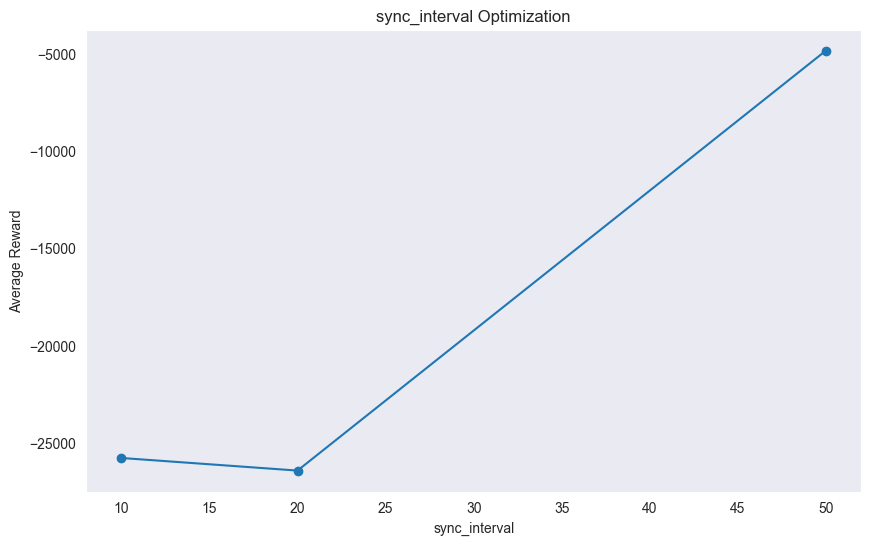

Optimal sync_interval: 50
Episode: 100, Total Reward: -618.0
Episode: 200, Total Reward: -176.0
hidden_dim: 32, Average Return: -3960.885
Episode: 100, Total Reward: -11528.0
Episode: 200, Total Reward: -373.0
hidden_dim: 64, Average Return: -32096.05
Episode: 100, Total Reward: -546.0
Episode: 200, Total Reward: -1739.0
hidden_dim: 128, Average Return: -3392.165


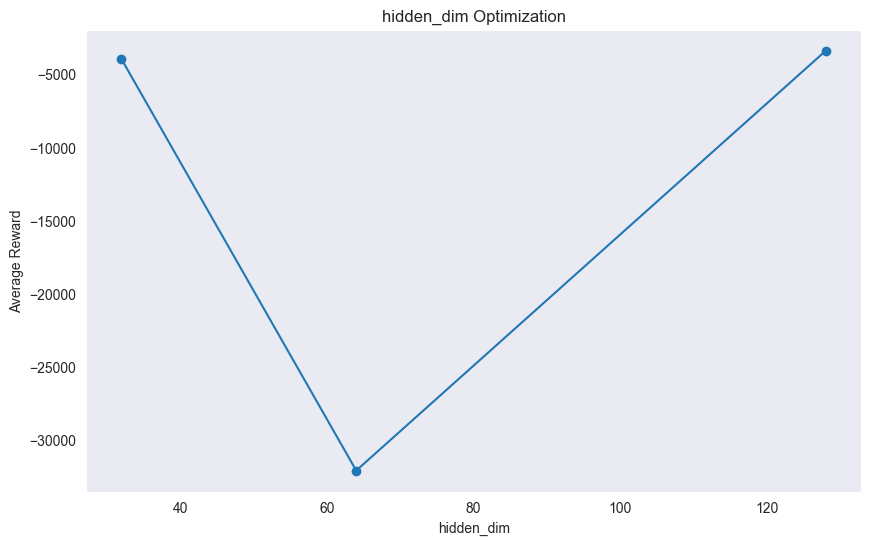

Optimal hidden_dim: 128
Optimal Parameters: {'gamma': 0.99, 'lr': 0.001, 'epsilon': 0.2, 'buffer_size': 1000, 'episodes': 100, 'sync_interval': 50, 'hidden_dim': 128}


In [1]:
# MountainCar DQN
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
from gymnasium.envs.classic_control import MountainCarEnv


# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim, gamma, lr, epsilon, buffer_size, sync_interval):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.buffer_size = buffer_size
        self.sync_interval = sync_interval

        self.memory = deque(maxlen=buffer_size)
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        # Define the Q-network and Target network
        self.q_network = self.build_network()
        self.target_network = self.build_network()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        self.steps = 0

    def build_network(self):
        return nn.Sequential(
            nn.Linear(self.state_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.action_dim)
        )

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.action_dim))
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.q_network(state_tensor)).item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size=64):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, target_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.sync_interval == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def update_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


# Training
def train_dqn(agent, env, episodes):
    returns = []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done)
            state = next_state

            total_reward += reward
            if done:
                break
            agent.train()

        agent.update_epsilon()
        returns.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

    return returns


# Hyperparameter 시각화
def plot_results(parameter_name, param_values, avg_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, avg_rewards, marker='o')
    plt.xlabel(parameter_name)
    plt.ylabel('Average Reward')
    plt.title(f'{parameter_name} Optimization')
    plt.grid()
    plt.show()


def hyperparameter_analysis(params, param_name, possible_values):
    env = MountainCarEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    rewards = []
    for value in possible_values:
        params[param_name] = value
        agent = DQNAgent(
            state_dim, action_dim, params['hidden_dim'], params['gamma'],
            params['lr'], params['epsilon'], params['buffer_size'], params['sync_interval']
        )

        avg_return = np.mean(train_dqn(agent, env, params['episodes']))
        rewards.append(avg_return)
        print(f"{param_name}: {value}, Average Return: {avg_return}")

    plot_results(param_name, possible_values, rewards)

    optimal_value = possible_values[np.argmax(rewards)]
    print(f"Optimal {param_name}: {optimal_value}")
    return optimal_value


# Main Program
if __name__ == '__main__':
    # Default Parameters
    params = {
        'gamma': 0.99,
        'lr': 0.001,
        'epsilon': 1.0,
        'buffer_size': 2000,
        'episodes': 50,
        'sync_interval': 10,
        'hidden_dim': 64
    }

    hyperparameters = {
        'gamma': [0.8, 0.9, 0.99],
        'lr': [0.0001, 0.001, 0.01],
        'epsilon': [0.1, 0.2, 0.5, 1.0],
        'buffer_size': [1000, 2000, 3000],
        'episodes': [50, 100, 200],
        'sync_interval': [10, 20, 50],
        'hidden_dim': [32, 64, 128]
    }

    optimal_params = {}
    for param_name, possible_values in hyperparameters.items():
        optimal_params[param_name] = hyperparameter_analysis(params, param_name, possible_values)

    print("Optimal Parameters:", optimal_params)


In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np

# 환경 설정
env = gym.make('MountainCar-v0',  render_mode="human")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# DQN 모델 정의
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.model(x)

# 하이퍼파라미터 설정
LR = 0.001
GAMMA = 0.99
EPSILON_START = 0.2
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
BUFFER_SIZE = 1000
BATCH_SIZE = 64
EPISODES = 50

# 모델 및 옵티마이저
q_network = DQN(state_dim, action_dim)
optimizer = optim.Adam(q_network.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# Replay buffer
replay_buffer = deque(maxlen=BUFFER_SIZE)

# Epsilon 초기화
epsilon = EPSILON_START

best_reward = -float('inf')
best_policy = None

# 메인 학습 루프
for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    terminated = truncated = False

    while not (terminated or truncated):
        # Epsilon-greedy 액션 선택
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = q_network(torch.FloatTensor(state)).argmax().item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        replay_buffer.append((state, action, reward, next_state, terminated))
        state = next_state

        # 경험이 충분히 쌓였을 때만 학습
        if len(replay_buffer) > BATCH_SIZE:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            # Q-learning 타겟
            current_q = q_network(states).gather(1, actions)
            next_q = q_network(next_states).max(1)[0].unsqueeze(1).detach()
            target_q = rewards + (GAMMA * next_q * (1 - dones))

            loss = loss_fn(current_q, target_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Epsilon 감소
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    print(f"Episode: {episode+1}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

    # 최고 reward일 때 모델 저장
    if total_reward > best_reward:
        best_reward = total_reward
        best_policy = DQN(state_dim, action_dim)
        best_policy.load_state_dict(q_network.state_dict())

env.close()
